# Optimized KNNImpute with BallTree

**Overview:** I tackled a work project that required us to impute values for Uber H3 hexagons across the United States. Almost 90% of these hexagons were missing variables of interest or "labels" (mostly related to prices), however they contained other identified information such as population/supply, which we'll call "factors". Because we had almost 250,000 hexagons, brute-force KNN imputation was extremely slow, so we needed a better alternative. The solution I designed was an approximate KNN imputation method leveraging BallTree, which improved computation time over 20x faster and allowed us to scale work more effectively. It's also worth mentioning that *imputation needed to be location specific*, so using something like KNNRegressor was not an option because it doesn't work with lat/lon data. Short of building a spatial regression method with BallTree, a simple imputation based on neighbors was the next best step.

**Technical Steps:**
1. Construct a BallTree on the labelled data factors
2. Query BallTree using factors from unlabelled data 
3. Estimate labels using "k" closest points in the BallTree

**Data Used:** 
Palmer Penguin dataset: https://gist.github.com/slopp/ce3b90b9168f2f921784de84fa445651

___

## 1. Preprocessing

#### 1.1 Imports

In [1]:
# Data Wrangling/Visualization 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

# Scientific Packages
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import BallTree
from sklearn.impute import KNNImputer
from imblearn.over_sampling import SMOTE

# Other
from collections import Counter
import itertools
import time

#### 1.2 Dataload & Quick Inspection

In [2]:
# Import data and look at means for each column
df = pd.read_csv('penguins.csv').dropna().drop(columns=['rowid'])
print(df.columns)
df.groupby('species').mean()

Index(['species', 'island', 'bill_length_mm', 'bill_depth_mm',
       'flipper_length_mm', 'body_mass_g', 'sex', 'year'],
      dtype='object')


,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,year
species,,,,,
Adelie,38.823973,18.347260,190.102740,3706.164384,2008.054795
Chinstrap,48.833824,18.420588,195.823529,3733.088235,2007.970588
Gentoo,47.568067,14.996639,217.235294,5092.436975,2008.067227


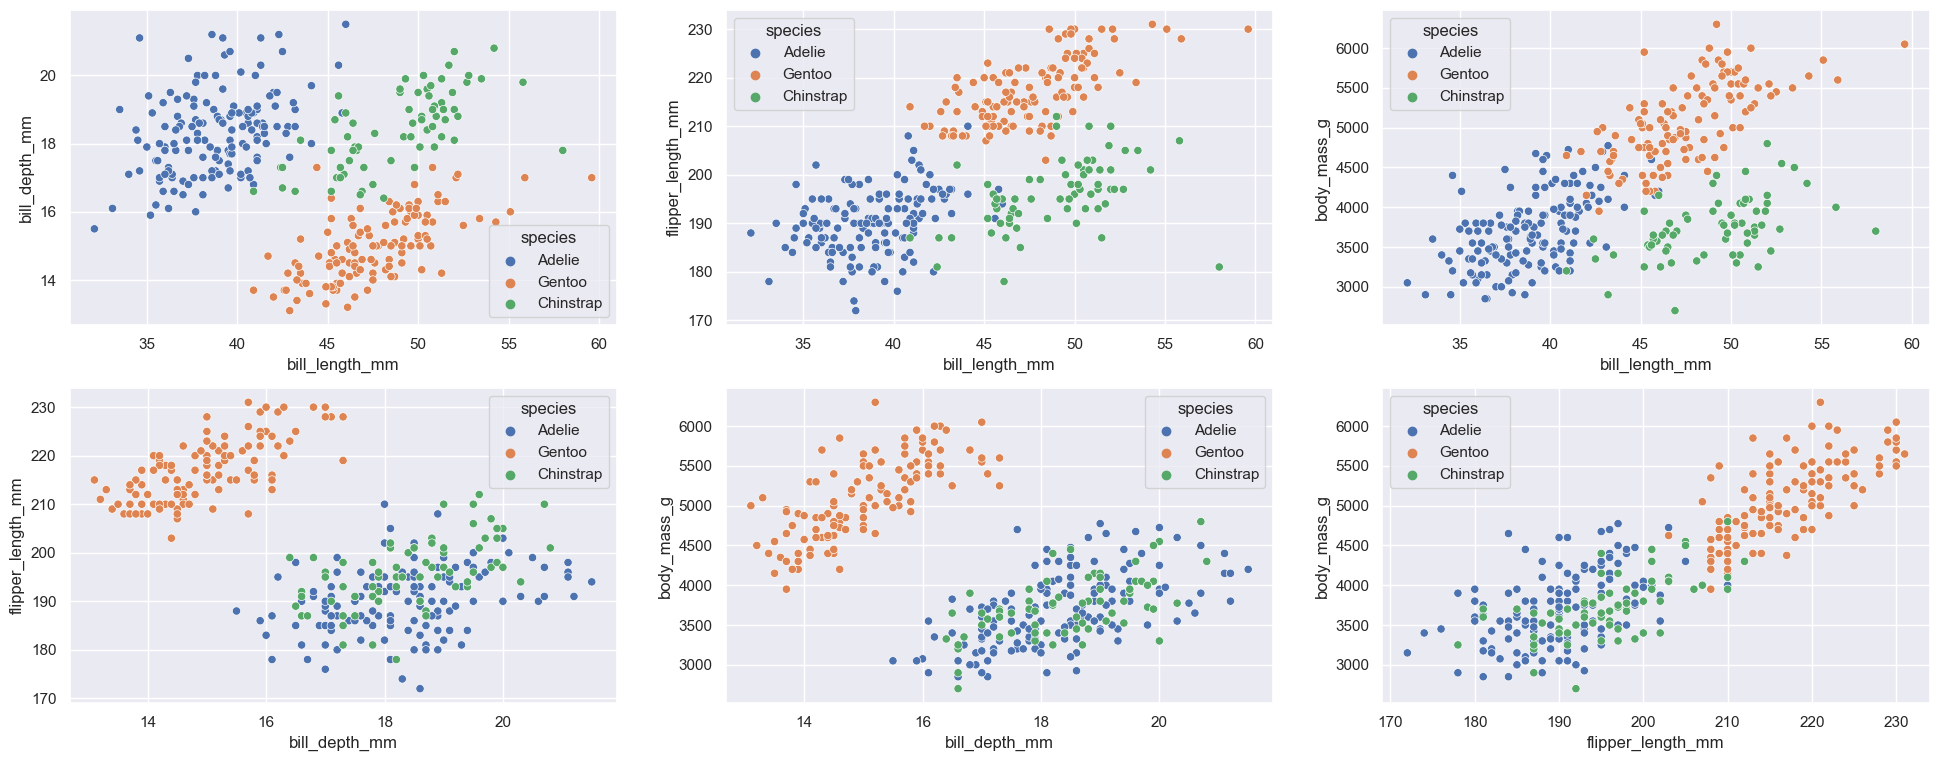

In [3]:
# Plot data in a grid and look at distribution of variables
cols = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']
pairs = [pair for pair in itertools.combinations(cols,2)]

# Layout of Subplots
# Determine the layout of the subplots
n = len(pairs)
rows = int(n ** 0.5)
cols = n // rows + (n % rows > 0)

# Plot variables
fig, axes = plt.subplots(rows, cols, figsize=(8*cols,3*cols))

axes = axes.flatten()

for ((col1, col2), ax) in zip(pairs, axes):
    sns.scatterplot(data=df,
                    x=col1,
                    y=col2,
                    hue='species',
                    ax=ax)

#### 1.3 Oversample Data
- We'll inflate this dataset in order to demonstrate performance gains. There won't be much of a performance difference at small scales between BallTreeImpute and KNNImpute.

In [4]:
# X, y for SMOTE input where y is category
X = df[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']]
y = df['species']

# Original Shape
print('Original dataset shape %s' % Counter(y))

# Define the sampling strategy
n = 50000
sampling_strategy = {species: int(count*n/len(df)) for species, count in df.species.value_counts().items()}

smote = SMOTE(sampling_strategy=sampling_strategy)
X_res, y_res = smote.fit_resample(X, y)

# Output Shape
print('Resampled dataset shape %s' % Counter(y_res))

# New Dataframe
dfn = X_res
dfn['species'] = y_res

Original dataset shape Counter({'Adelie': 146, 'Gentoo': 119, 'Chinstrap': 68})
Resampled dataset shape Counter({'Adelie': 21921, 'Gentoo': 17867, 'Chinstrap': 10210})


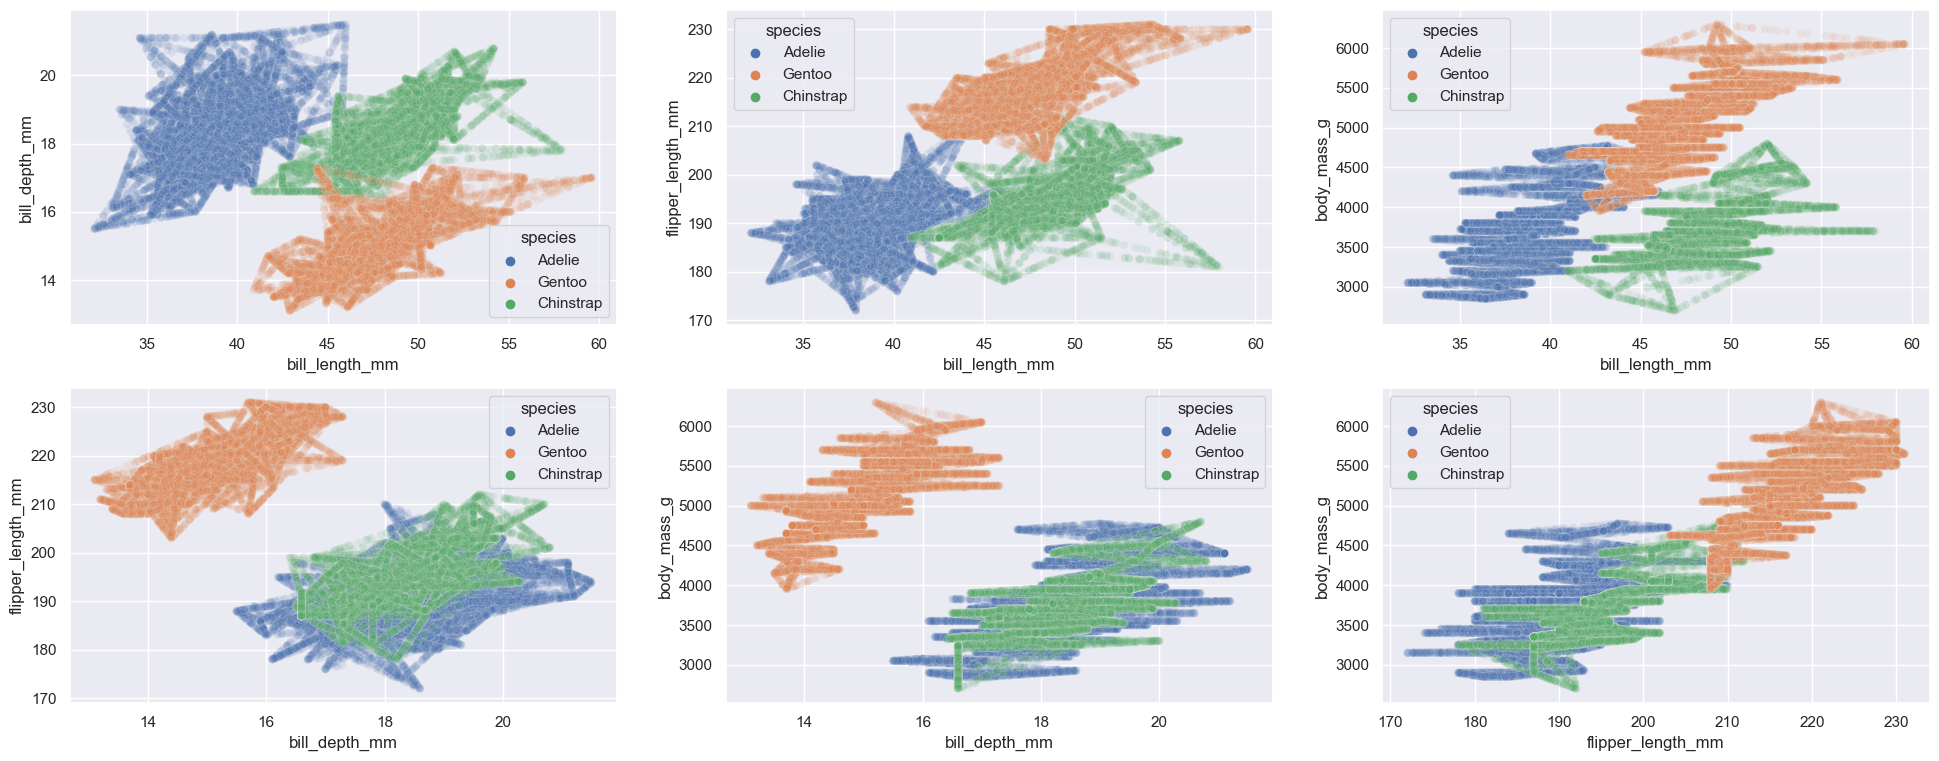

In [5]:
# Plot data in a grid and look at distribution of variables
cols = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']
pairs = [pair for pair in itertools.combinations(cols,2)]

# Layout of Subplots
# Determine the layout of the subplots
n = len(pairs)
rows = int(n ** 0.5)
cols = n // rows + (n % rows > 0)

# Plot variables
fig, axes = plt.subplots(rows, cols, figsize=(8*cols,3*cols))

axes = axes.flatten()

for ((col1, col2), ax) in zip(pairs, axes):
    sns.scatterplot(data=dfn,
                    x=col1,
                    y=col2,
                    hue='species',
                    ax=ax,
                    alpha=0.1)

#### 1.3 NaN 50% of Bill Length Values
- Bill length will be our de-facto "target" column for the purposes of this notebook

In [6]:
# Copy df, take random sample
dfa = dfn.copy()
null_indices = dfa.sample(frac=0.85).index

# Set target variable and duplicate column
target = 'bill_length_mm'
dfa[f'{target}_target'] = dfa[target]

# Null target column based on indices
dfa.loc[null_indices, f'{target}_target'] = np.nan

# Preview
dfa.head(5)

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,species,bill_length_mm_target
0,39.1,18.7,181.0,3750.0,Adelie,NaN
1,39.5,17.4,186.0,3800.0,Adelie,NaN
2,40.3,18.0,195.0,3250.0,Adelie,NaN
3,36.7,19.3,193.0,3450.0,Adelie,NaN
4,39.3,20.6,190.0,3650.0,Adelie,NaN


#### 1.4 Re-plot Target and Factors with Markers for NaN 

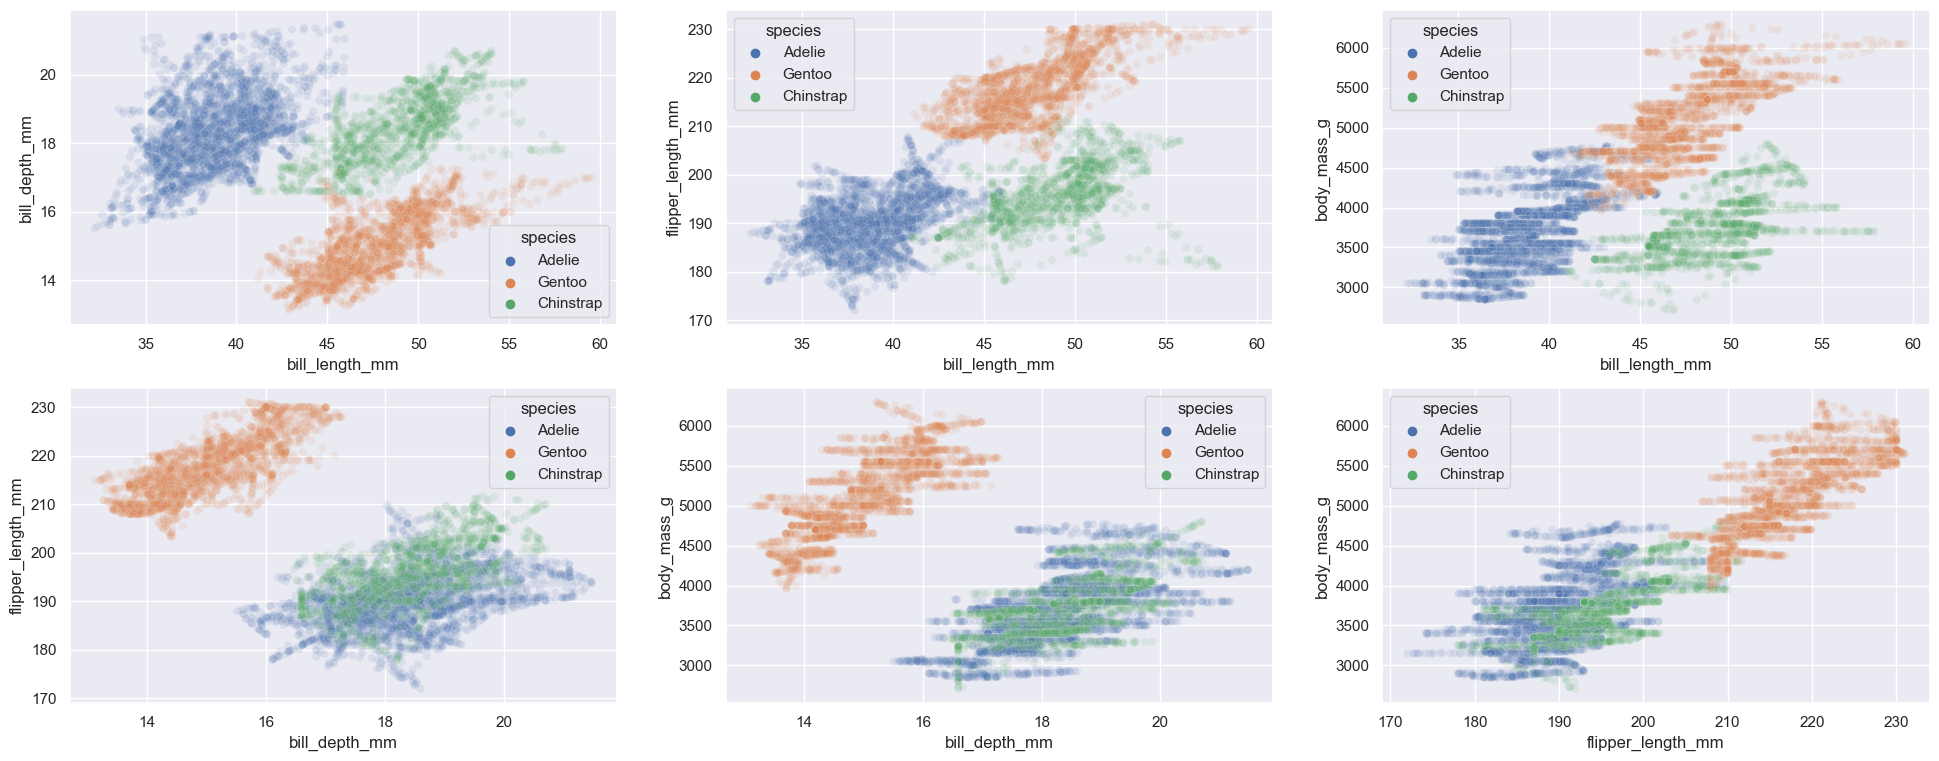

In [7]:
dfa['markers'] = dfa['bill_length_mm_target'].apply(lambda x: 1 if pd.isna(x) else 0)

# Plot data in a grid and look at distribution of variables
cols = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']
pairs = [pair for pair in itertools.combinations(cols,2)]

# Layout of Subplots
# Determine the layout of the subplots
n = len(pairs)
rows = int(n ** 0.5)
cols = n // rows + (n % rows > 0)

# Plot variables
fig, axes = plt.subplots(rows, cols, figsize=(8*cols,3*cols))

axes = axes.flatten()

for ((col1, col2), ax) in zip(pairs, axes):
    sns.scatterplot(data=dfa[dfa.markers==0],
                    x=col1,
                    y=col2,
                    hue='species',
                    ax=ax,
                   alpha=0.1)

#### 1.5 Summary
Our data is ready to be imputed at this point. As an aside, we can see that SMOTE doesn't do the greatest job at generating synthetic samples as evidenced by the many straight lines in the graphs. At it's core, SMOTE simply chooses nearest neighbors and picks a point somewhere in between those neighbors as the new sample. This is a rather naive approach, but it works fior this exercise.

___

## 2. Imputation

#### 2.1 KNN Imputation

In [8]:
def knn_impute(df, feature_cols, target_col, k):
    # Standardize feature columns
    scaler = StandardScaler()
    cols = feature_cols + target_col
    df_scaled = df[cols].copy()
    df_scaled = scaler.fit_transform(df_scaled)
    
    # Fit-transform KNNImputer
    imputer = KNNImputer(n_neighbors=2)
    df_transformed = imputer.fit_transform(df_scaled)
    
    # Rescale data
    df_transformed = scaler.inverse_transform(df_transformed)
    df_transformed = pd.DataFrame(df_transformed, columns=cols)
    df_transformed['species'] = df.species
    df_transformed['markers'] = df.markers
    df_transformed['bill_length_mm'] = df.bill_length_mm
    
    return df_transformed

In [9]:
%%time
df_knn = knn_impute(dfa, ['bill_depth_mm', 'flipper_length_mm', 'body_mass_g'], ['bill_length_mm_target'], 10)
df_knn.head(10)

CPU times: user 1min 13s, sys: 1min 37s, total: 2min 50s
Wall time: 51.8 s


,bill_depth_mm,flipper_length_mm,body_mass_g,bill_length_mm_target,species,markers,bill_length_mm
0,18.7,181.0,3750.0,39.059303,Adelie,1,39.1
1,17.4,186.0,3800.0,39.462784,Adelie,1,39.5
2,18.0,195.0,3250.0,40.274115,Adelie,1,40.3
3,19.3,193.0,3450.0,36.701500,Adelie,1,36.7
4,20.6,190.0,3650.0,39.285763,Adelie,1,39.3
5,17.8,181.0,3625.0,38.780968,Adelie,1,38.9
6,19.6,195.0,4675.0,39.459373,Adelie,1,39.2
7,17.6,182.0,3200.0,40.970325,Adelie,1,41.1
8,21.2,191.0,3800.0,38.561372,Adelie,1,38.6
9,21.1,198.0,4400.0,35.107858,Adelie,1,34.6


In [10]:
def knn_balltree_impute(df, feature_cols, target_col, k):
    # Output dataframe
    df_out = df.copy()
    
    # Standardize feature columns
    scaler = StandardScaler()
    cols = feature_cols + [target_col]
    df_scaled = df[cols].copy()
    df_scaled[feature_cols] = scaler.fit_transform(df_scaled[feature_cols])

    # Dataframe filtered to exclude empty values 
    df_filtered = df_scaled[df_scaled[target_col].notna()]
    
    # Create BallTree
    tree = BallTree(df_filtered[feature_cols], metric='euclidean')

    # Empty list to hold updates
    update_vals = []

    # Impute missing values
    for idx, row in df_scaled[df_scaled[target_col].isna()].iterrows():

        # Find k nearest neighbors based on features
        point = row[feature_cols].values
        dist, ind = tree.query([point], k=k)
        neighbors = ind[0]

        # Get target values for the neighbors
        neighbor_values = df_filtered.iloc[neighbors][target_col]

        # Calculate the weighted sum 
        weights = 1/(dist[0]+0.0001)  # inverse distance weighting; dist can be zero, so we need to offset denom slightly
        weighted_sum = np.dot(weights, neighbor_values)
        total_weight = np.sum(weights)

        # Impute missing value
        imputed_value = weighted_sum / total_weight

        update_vals.append({f'index': idx,
                            target_col: imputed_value})

    df_new = pd.DataFrame(update_vals).set_index(f'index')
    df_out.update(df_new)

    return df_out

In [11]:
%%time
df_bt = knn_balltree_impute(dfa, ['bill_depth_mm', 'flipper_length_mm', 'body_mass_g'], 'bill_length_mm_target', 10)
df_bt.head(10)

CPU times: user 13.5 s, sys: 16.7 ms, total: 13.5 s
Wall time: 13.5 s


,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,species,bill_length_mm_target,markers
0,39.1,18.7,181.0,3750.0,Adelie,38.996722,1
1,39.5,17.4,186.0,3800.0,Adelie,39.432128,1
2,40.3,18.0,195.0,3250.0,Adelie,40.430085,1
3,36.7,19.3,193.0,3450.0,Adelie,36.730383,1
4,39.3,20.6,190.0,3650.0,Adelie,38.938518,1
5,38.9,17.8,181.0,3625.0,Adelie,45.462563,1
6,39.2,19.6,195.0,4675.0,Adelie,39.329830,1
7,41.1,17.6,182.0,3200.0,Adelie,41.090798,1
8,38.6,21.2,191.0,3800.0,Adelie,38.509468,1
9,34.6,21.1,198.0,4400.0,Adelie,36.166185,1


#### 2.2 Error Comparison

In [12]:
# Average error
df_bt['error'] = df_bt.apply(lambda x: x.bill_length_mm_target-x.bill_length_mm if x.markers==1 else np.nan, axis=1)
df_knn['error'] = df_knn.apply(lambda x: x.bill_length_mm_target-x.bill_length_mm if x.markers==1 else np.nan, axis=1)

# Percent Error
df_bt['p_error'] = df_bt.apply(lambda x: abs(x.bill_length_mm_target-x.bill_length_mm)*100/x.bill_length_mm if x.markers==1 else np.nan, axis=1)
df_knn['p_error'] = df_knn.apply(lambda x: abs(x.bill_length_mm_target-x.bill_length_mm)*100/x.bill_length_mm if x.markers==1 else np.nan, axis=1)

In [13]:
print(f'BallTree Average Error & Percent Error: ({round(df_bt.error.mean(),4)}, {round(df_bt.p_error.mean(),2)})')
print(f'KNN Average Error & Percent Error: ({round(df_knn.error.mean(),4)}, {round(df_knn.p_error.mean(),2)})')

BallTree Average Error & Percent Error: (-0.063, 2.18)
KNN Average Error & Percent Error: (-0.0445, 1.67)


KNN does perform better than the BallTree approximation, however the 0.5% error mitigation is not enough to outweigh the efficiency gains by using an approximation method. Below we'll look at speed and error as sample size increases to see why KNN quickly becomes unusable in production settings.

___

## 3. Performance Comparison

#### 3.1 Data Generator Class
- This will make it easier to generate comparison data within loops.

In [14]:
class DataGenerator:
    def __init__(self, df):
        '''
        Class is intialized with only the base dataframe.
        '''
        self.df = df.copy()
        
    def oversample(self, n=None):
        '''
        Oversample the base dataframe. User specifies length of oversampled dataframe with n.
        This method updates self.df in place.
        '''
        # Gather features and target for SMOTE
        X = self.df[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']]
        y = self.df['species']

        # Define the sampling strategy
        if n:
            sampling_strategy = {species: int(count*n/len(self.df)) for species, count in self.df.species.value_counts().items()}
        else:
            raise ValueError('Provide n for oversampling')          
        
        # Perform SMOTE
        smote = SMOTE(sampling_strategy=sampling_strategy)
        X_res, y_res = smote.fit_resample(X, y)

        # Update dataframe with oversampled data
        self.df = X_res
        self.df['species'] = y_res
        
        return self.df
        
    def create_nulls(self, frac=None):
        '''
        Creates nulls in the current dataframe. 'frac' specifies the percentage of values that will be nulled.
        This method can be applied directly to the base dataframe or the oversampled dataframe.
        '''
        
        # Take random sample
        if frac:
            null_indices = self.df.sample(frac=frac).index
        else:
            raise ValueError('Provide "frac" to create nulls.')

        # Set target variable and duplicate column
        target = 'bill_length_mm'
        self.df[f'{target}_target'] = self.df[target]

        # Null target column based on indices
        self.df.loc[null_indices, f'{target}_target'] = np.nan
        
        # Create column to mark where null was made
        self.df['markers'] = self.df['bill_length_mm_target'].apply(lambda x: 1 if pd.isna(x) else 0)
        
        return self.df
        
    def oversample_and_create_nulls(self, n=None, frac=None):
        '''
        Convenience method that combines create_nulls and oversample methods into one.
        '''
        
        if not n or not frac:
            raise ValueError('Parameters n and frac must be provided.')
        else:
            self.oversample(n=n)
            self.create_nulls(frac=frac)
            
        return self.df

#### 3.2 Data Generation
- Will look at n from current length of dataframe up to 10,000

In [15]:
samples = list(np.arange(len(df), 50333, 5000))

#### 3.3 KNN and BallTree Imputation

In [16]:
data = {}
for idx, n in enumerate(samples):
    # Oversampled and nulled dataframe
    dg = DataGenerator(df)
    df_on = dg.oversample_and_create_nulls(n=n, frac=0.85)
    
    # KNN
    start = time.time()
    knn = knn_impute(df_on, ['bill_depth_mm', 'flipper_length_mm', 'body_mass_g'], ['bill_length_mm_target'], 10)
    time_elapsed = round(time.time()-start, 2)
    
    knn['p_error'] = knn.apply(lambda x: abs(x.bill_length_mm_target-x.bill_length_mm)*100/x.bill_length_mm if x.markers==1 else np.nan, axis=1)
    p_error = round(knn.p_error.mean(),2)
    
    data[(f'{n}', 'KNN')] = {'time': time_elapsed, 'percent_error': p_error}
    
    
    # BallTree
    start = time.time()
    bt = knn_balltree_impute(df_on, ['bill_depth_mm', 'flipper_length_mm', 'body_mass_g'], 'bill_length_mm_target', 10)
    time_elapsed = round(time.time()-start, 2)
    
    bt['p_error'] = bt.apply(lambda x: abs(x.bill_length_mm_target-x.bill_length_mm)*100/x.bill_length_mm if x.markers==1 else np.nan, axis=1)
    p_error = round(bt.p_error.mean(),2)
    
    data[(f'{n}', 'BallTree')] = {'time': time_elapsed, 'percent_error': p_error}
    
    print(f'COMPLETE: n={n}')

COMPLETE: n=333
COMPLETE: n=5333
COMPLETE: n=10333
COMPLETE: n=15333
COMPLETE: n=20333
COMPLETE: n=25333
COMPLETE: n=30333
COMPLETE: n=35333
COMPLETE: n=40333
COMPLETE: n=45333


#### 3.4 Performance

In [20]:
# Create a MultiIndex 
index = pd.MultiIndex.from_tuples(data.keys(), names=['obs', 'type'])

# Create output dataframe
plot = pd.DataFrame(list(data.values()), index=index, columns=['time', 'percent_error']).reset_index()

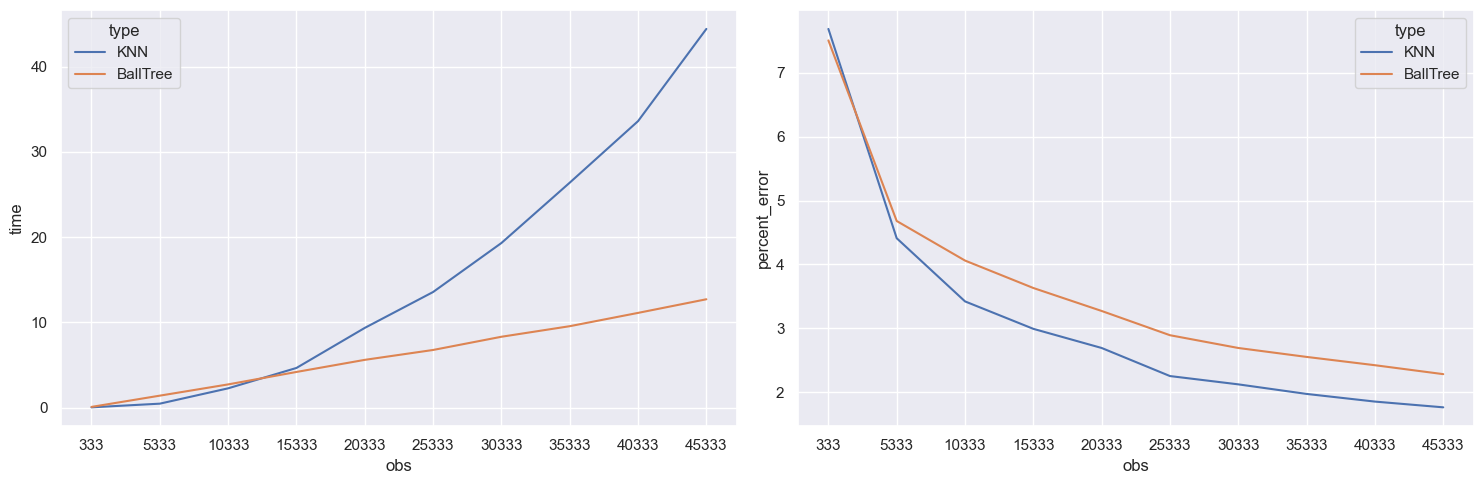

In [29]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

sns.lineplot(data=plot, x='obs', y='time', hue='type', ax=ax[0])
sns.lineplot(data=plot, x='obs', y='percent_error', hue='type', ax=ax[1])
fig.tight_layout()

### Results
For observations < 15000, there is no real advantage to using the approximate KNN method with BallTree versus the true KNN method. However, as the dataset grows in size it becomes readily apparent that KNN impute is not a viable option. In my work example, KNN took over 30 minutes for 250,000 samples while the BallTree method took only 90s; this was the difference between a method that could move to production and one that could not given our constraints. 

As we can see on the right graph, the tradeoff in error is less than half a percent, which (while not small) is acceptable considering the time savings.

___